<a href="https://colab.research.google.com/github/changsksu/IMSE_Data_Science/blob/main/CCD_2nd_Order_Fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This Python notebook demonstrates anaysis of Contral Composite Desgin (CCD). 

We take the advantage of the polynomial generation feature to generate full dimension of the design matrix x using sklearn PolynomialFeature. The example is from Montgomery Intro to SQC (7th ed chap 13 Ex 14.2 CCD for Etch Rate Gap & Power).  Ref.
https://www.statsmodels.org/stable/regression.html#examples

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html 


In [ ]:
import math
import random
import scipy
import statistics
import numpy as np
import scipy.stats
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import plotly.graph_objects as go
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as mc
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
#use theread option where the data file is rignt under your default google drive directory
#note that the path is case sensitive
#use a text editor such as notepad to see the seperator dividing data
#go the 1st read option for local file: see the Read data from local file notebook for an example
# factor A is the cutting speed and factor B is feed rate and C is the tool angle and the response is surface finish
# the run_oder is the order when the combination was experimented which will be used for plotting residuals
data = pd.read_csv('https://raw.githubusercontent.com/changsksu/KState_IMSE541/main/EX%2014.2.csv', sep=',', na_values=".")

data  

,Gap,Power,x1,x4,y1,y2
0,0.600,350.0,-1.000,-1.000,1054,79.6
1,1.000,350.0,1.000,-1.000,936,81.3
2,0.600,400.0,-1.000,1.000,1179,78.5
3,1.000,400.0,1.000,1.000,1417,97.7
4,0.517,375.0,-1.414,0.000,1049,76.4
5,1.083,375.0,1.414,0.000,1287,88.1
6,0.800,339.6,0.000,-1.414,927,78.5
7,0.800,410.0,0.000,1.414,1345,92.3
8,0.800,375.0,0.000,0.000,1151,90.1
9,0.800,375.0,0.000,0.000,1150,88.3


In [ ]:
#creat a 3D surface plot for data visualization
#response on z axis is the raw data SF
z = data.values #data values without heading
sh_0, sh_1 = z.shape # dimension of the data matrix or table
x1, x2 = np.linspace(-1, 1, sh_1), np.linspace(-1, 1, sh_1)
#print(x1)
#print(x2)
#print(z)
z2=data[['Gap','Power', 'y1']]
fig = go.Figure(data=[go.Surface(z=z2, x=x1, y=x2)])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(title='Surface Plot', autosize=False,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90)
)
fig.update_layout(scene = dict(
                    xaxis_title='Gap',
                    yaxis_title='Power',
                    zaxis_title='Etch Rate'),
                   )
fig.show()


# Can you use the 3D and contour to identify the factor combination that maximiaed the etch rate?

In [ ]:
df=data #df means data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gap     12 non-null     float64
 1   Power   12 non-null     float64
 2   x1      12 non-null     float64
 3   x4      12 non-null     float64
 4   y1      12 non-null     int64  
 5   y2      12 non-null     float64
dtypes: float64(5), int64(1)
memory usage: 704.0 bytes


In [ ]:
X=df[['x1', 'x4']]
X

,x1,x4
0,-1.000,-1.000
1,1.000,-1.000
2,-1.000,1.000
3,1.000,1.000
4,-1.414,0.000
5,1.414,0.000
6,0.000,-1.414
7,0.000,1.414
8,0.000,0.000
9,0.000,0.000


In [ ]:
# convert x1 and x4 input columns into a 2nd order polynomial matrix with intercept column 
# computation is done in numpy and convert it into Panda dataframe
xx=X.to_numpy()
poly= PolynomialFeatures(degree=2, interaction_only=False)
xxpd=pd.DataFrame(poly.fit_transform(xx), columns=['I', 'x1', 'x4', 'x1^2', 'x1x4', 'x4^2']) #if interaction_only=False, then 1, x1, x2, x1^2, x1x2, x2^2
xxpd

,I,x1,x4,x1^2,x1x4,x4^2
0,1.0,-1.000,-1.000,1.000000,1.0,1.000000
1,1.0,1.000,-1.000,1.000000,-1.0,1.000000
2,1.0,-1.000,1.000,1.000000,-1.0,1.000000
3,1.0,1.000,1.000,1.000000,1.0,1.000000
4,1.0,-1.414,0.000,1.999396,-0.0,0.000000
5,1.0,1.414,0.000,1.999396,0.0,0.000000
6,1.0,0.000,-1.414,0.000000,-0.0,1.999396
7,1.0,0.000,1.414,0.000000,0.0,1.999396
8,1.0,0.000,0.000,0.000000,0.0,0.000000
9,1.0,0.000,0.000,0.000000,0.0,0.000000


Note that the x1^2 and X2^2 columns are all 1s. This phenomial is due the lack of center points and middle level points in the design matrix X. We will introduce a CCD (central composite design) to take care of it.

In [ ]:
# generate model = b0 + b1x1 + b2x2 + b3x3+ two factor interactions + b123x1x2x3
# this is a model for 2^k factorial design so 2nd order terms are not estimatable
X=xxpd[['x1', 'x4', 'x1^2', 'x1x4', 'x4^2']]
X

,x1,x4,x1^2,x1x4,x4^2
0,-1.000,-1.000,1.000000,1.0,1.000000
1,1.000,-1.000,1.000000,-1.0,1.000000
2,-1.000,1.000,1.000000,-1.0,1.000000
3,1.000,1.000,1.000000,1.0,1.000000
4,-1.414,0.000,1.999396,-0.0,0.000000
5,1.414,0.000,1.999396,0.0,0.000000
6,0.000,-1.414,0.000000,-0.0,1.999396
7,0.000,1.414,0.000000,0.0,1.999396
8,0.000,0.000,0.000000,0.0,0.000000
9,0.000,0.000,0.000000,0.0,0.000000


In [ ]:
# predicted response using skleran LinearRegression fit
Y=df[['y1']]
regr=LinearRegression()
regr.fit(X,Y)
Yhat=regr.predict(X)
Yhat

array([[1031.51746164],
       [ 967.66769832],
       [1152.82565718],
       [1444.97589386],
       [1084.54827517],
       [1245.95670984],
       [ 921.64159826],
       [1344.86338675],
       [1168.50082975],
       [1168.50082975],
       [1168.50082975],
       [1168.50082975]])

In [ ]:
# add the column of 1s into the design matrix X
# another way is to reconstruct X using xxpd from the previous code cell
# X=xxpd[['I', 'x1', 'x2', 'x1x2']]
X = sm.add_constant(X)
X

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



,const,x1,x4,x1^2,x1x4,x4^2
0,1.0,-1.000,-1.000,1.000000,1.0,1.000000
1,1.0,1.000,-1.000,1.000000,-1.0,1.000000
2,1.0,-1.000,1.000,1.000000,-1.0,1.000000
3,1.0,1.000,1.000,1.000000,1.0,1.000000
4,1.0,-1.414,0.000,1.999396,-0.0,0.000000
5,1.0,1.414,0.000,1.999396,0.0,0.000000
6,1.0,0.000,-1.414,0.000000,-0.0,1.999396
7,1.0,0.000,1.414,0.000000,0.0,1.999396
8,1.0,0.000,0.000,0.000000,0.0,0.000000
9,1.0,0.000,0.000,0.000000,0.0,0.000000


In [ ]:
# use statsmodels for OLS fitting and t statistics
# in this case, X is xxpd
model = sm.OLS(Y, X)
res=model.fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:                     y1   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     38.58
Date:                Tue, 18 Oct 2022   Prob (F-statistic):           0.000174
Time:                        22:11:32   Log-Likelihood:                -55.598
No. Observations:                  12   AIC:                             123.2
Df Residuals:                       6   BIC:                             126.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1168.5008     17.595     66.411      0.0

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1542: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=12



from the t tests above, the significant factors are

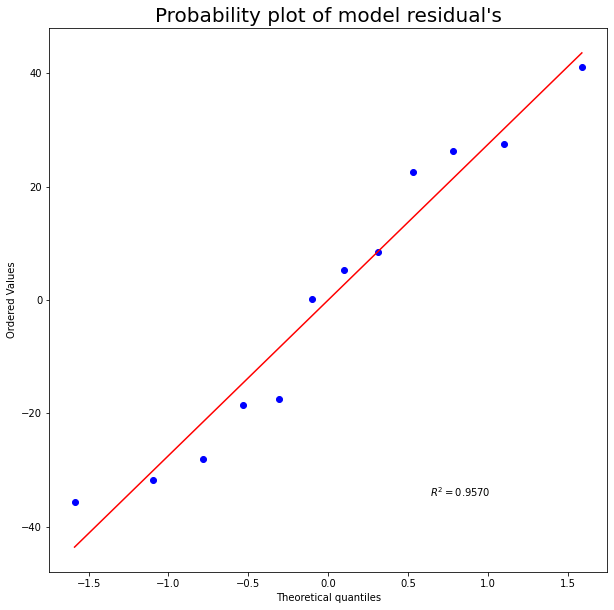

In [ ]:
# Residual Analysis
# normal check

fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(res.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 20)
ax.set

plt.show()

The above probably plot shows that the residuals are not normal. Your turn: check constant variance & independence assumption

The random order from the scatter plot above shows no pattern. If the data in the first half of the experiments are lower than 0 while those of the second half are above 0. Then there is a bias in data collection. If the residuals are small in the beginning but graduately increase. Or vice versa. It is a concern as well. In these cases, independence assumption is violated.

In [ ]:
#running the uniformity response Y2

Y2=df[['y2']]
model = sm.OLS(Y2, X)
res=model.fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     75.11
Date:                Tue, 18 Oct 2022   Prob (F-statistic):           2.51e-05
Time:                        22:18:17   Log-Likelihood:                -14.417
No. Observations:                  12   AIC:                             40.83
Df Residuals:                       6   BIC:                             43.74
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         89.2749      0.569    156.937      0.0

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1542: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=12



In [ ]:
# fit the regression 
Y2=df[['y2']]
regr=LinearRegression()
regr.fit(X,Y2)
Yhat=regr.predict(X)
Yhat

array([[79.39075596],
       [80.00311968],
       [79.34537036],
       [97.45773408],
       [75.85663203],
       [89.09501433],
       [79.4716608 ],
       [91.77998556],
       [89.2749318 ],
       [89.2749318 ],
       [89.2749318 ],
       [89.2749318 ]])

In [ ]:
#creat a 3D surface plot for data visualization
#response on z axis is the raw data Etch Rate
z = data.values #data values without heading
sh_0, sh_1 = z.shape # dimension of the data matrix or table
x1, x2 = np.linspace(-1, 1, sh_1), np.linspace(-1, 1, sh_1)
#print(x1)
#print(x2)
#print(z)
z2=data[['Gap','Power', 'y1']]
fig = go.Figure(data=[go.Surface(z=z2, x=x1, y=x2)])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(title='Surface Plot', autosize=False,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90)
)
fig.update_layout(scene = dict(
                    xaxis_title='Gap',
                    yaxis_title='Power',
                    zaxis_title='Etch Rate'),
                   )
fig.show()

In [ ]:
#creat a 3D surface plot for data visualization
#response on z axis is the raw data SF
z = data.values #data values without heading
sh_0, sh_1 = z.shape # dimension of the data matrix or table
x1, x2 = np.linspace(-1, 1, sh_1), np.linspace(-1, 1, sh_1)
#print(x1)
#print(x2)
#print(z)
z2=data[['Gap','Power', 'y2']]
fig = go.Figure(data=[go.Surface(z=z2, x=x1, y=x2)])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(title='Surface Plot', autosize=False,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90)
)
fig.update_layout(scene = dict(
                    xaxis_title='Gap',
                    yaxis_title='Power',
                    zaxis_title='Uniformity'),
                   )
fig.show()

# Can you use the 3D and contour plots from both y1 and y2 to identify the factor region that maximize the etch rate y1 but minimized y2?